In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import *

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='white')

# [0] 데이터 불러오기

In [10]:
train = pd.read_csv('new_df_21_v2.csv', sep=',', encoding='UTF-8')
test = pd.read_csv('new_df_22_v2.csv', sep=',', encoding='UTF-8')

print(train.shape, test.shape)

(8759, 55) (2159, 55)


In [11]:
train.isna().sum()

SO2              0
CO               0
O3               0
NO2              0
PM10             0
PM25             0
일시               0
기온(°C)           0
강수량(mm)          0
풍속(m/s)          0
풍향(16방위)         0
습도(%)            0
증기압(hPa)         0
이슬점온도(°C)        0
현지기압(hPa)        0
해면기압(hPa)        0
일조(hr)           0
일사(MJ/m2)        0
일몰 여부            0
적설(cm)           0
3시간신적설(cm)       0
전운량(10분위)        0
중하층운량(10분위)      0
시정(10m)          0
지면온도(°C)         0
5cm 지중온도(°C)     0
10cm 지중온도(°C)    0
20cm 지중온도(°C)    0
30cm 지중온도(°C)    0
현상번호(0)          0
현상번호(1)          0
현상번호(2)          0
현상번호(4)          0
현상번호(5)          0
현상번호(6)          0
현상번호(10)         0
현상번호(11)         0
현상번호(16)         0
현상번호(19)         0
현상번호(40)         0
현상번호(42)         0
운형(Ci)           0
운형(Cc)           0
운형(Cs)           0
운형(Ac)           0
운형(As)           0
운형(Ns)           0
운형(Sc)           0
운형(St)           0
운형(Cu)           0
운형(Cb)           0
mean             0
O3+NO2      

In [12]:
train.head()

,SO2,CO,O3,NO2,PM10,PM25,일시,기온(°C),강수량(mm),풍속(m/s),...,운형(As),운형(Ns),운형(Sc),운형(St),운형(Cu),운형(Cb),mean,O3+NO2,hot_summer,hot_summer2
0,0.002,0.5,0.022,0.016,24.0,14.0,2021-01-01 01:00:00,-8.7,0.0,2.4,...,0,0,0,0,0,0,0.13500,0.019,0,0
1,0.002,0.6,0.018,0.020,25.0,14.0,2021-01-01 02:00:00,-9.1,0.0,1.6,...,0,0,0,0,0,0,0.16000,0.019,0,0
2,0.002,0.6,0.013,0.025,27.0,16.0,2021-01-01 03:00:00,-9.3,0.0,1.1,...,0,0,0,0,0,0,0.16000,0.019,0,0
3,0.003,0.6,0.011,0.027,23.0,13.0,2021-01-01 04:00:00,-9.3,0.0,0.3,...,0,0,0,0,0,0,0.16025,0.019,0,0
4,0.003,0.6,0.008,0.032,24.0,14.0,2021-01-01 05:00:00,-9.7,0.0,1.9,...,0,0,0,0,0,0,0.16075,0.020,0,0


In [5]:
train.columns

Index(['SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25', '일시', '기온(°C)', '강수량(mm)',
       '풍속(m/s)', '풍향(16방위)', '습도(%)', '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)',
       '해면기압(hPa)', '일조(hr)', '일사(MJ/m2)', '일몰 여부', '적설(cm)', '3시간신적설(cm)',
       '전운량(10분위)', '중하층운량(10분위)', '시정(10m)', '지면온도(°C)', '5cm 지중온도(°C)',
       '10cm 지중온도(°C)', '20cm 지중온도(°C)', '30cm 지중온도(°C)', '현상번호(0)', '현상번호(1)',
       '현상번호(2)', '현상번호(4)', '현상번호(5)', '현상번호(6)', '현상번호(10)', '현상번호(11)',
       '현상번호(16)', '현상번호(19)', '현상번호(40)', '현상번호(42)', '운형(Ci)', '운형(Cc)',
       '운형(Cs)', '운형(Ac)', '운형(As)', '운형(Ns)', '운형(Sc)', '운형(St)', '운형(Cu)',
       '운형(Cb)', 'mean', 'O3+NO2', 'hot_summer', 'hot_summer2'],
      dtype='object')

* mean : SO2+CO+O3+NO2의 평균
* O3+NO2 : 이산화 + 오존의 평균
* hot_summer : 2일 연속 35도 이상인 날 폭염(기온 기준)
* hot_summer2 : 2일 연속 35도 이상인 날 폭염(지연온도 기준)

In [13]:
train['y']=train['PM10'].shift(-1)
train.dropna(axis=0, inplace = True)
train_x=train.drop(['y', '일시'],axis=1)
train_y=train.loc[:,'y']

print(train_x.shape, train_y.shape)

(8758, 54) (8758,)


In [14]:
test['y']=test['PM10'].shift(-1)
test.dropna(axis=0, inplace = True)
test_x=test.drop(['y', '일시'],axis=1)
test_y=test.loc[:,'y']

print(test_x.shape, test_y.shape)

(2158, 54) (2158,)


# [1] Modeling

## 1. Linear Regression

### 1) Default Model & Time-Series Cross-Validation

In [8]:
# 1. 모델 선언
lr=LinearRegression()
lr.fit(train_x, train_y)

LinearRegression()

In [9]:
# 2. Time Series Cross Validation
from sklearn.model_selection import TimeSeriesSplit

K=12
tscv = TimeSeriesSplit(n_splits=K)

R2=[]
RMSE=[]
MAE=[]
MAPE=[]
    
for i, (train_index, val_index) in enumerate(tscv.split(train_x)):
    print(f'{i+1:2d} 번째 CV : Train 길이 {len(train_index):4d} & Val: {len(val_index)}')
    X_train, X_val = train_x.loc[list(train_index),:], train_x.loc[list(val_index),:]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    model=LinearRegression()
    model.fit(X_train, y_train)
    pred=model.predict(X_val)
    
    R2.append(r2_score(y_val, pred))
    RMSE.append(mean_squared_error(y_val, pred, squared = False))
    MAE.append(mean_absolute_error(y_val, pred))
    MAPE.append(mean_absolute_percentage_error(y_val, pred))

print()

print('R2 : ', round(sum(R2)/K,4))
print('RMSE : ', round(sum(RMSE)/K,4))
print('MAE  : ', round(sum(MAE)/K,4))
print('MAPE : ', round(sum(MAPE)/K,4))  

 1 번째 CV : Train 길이  682 & Val: 673
 2 번째 CV : Train 길이 1355 & Val: 673
 3 번째 CV : Train 길이 2028 & Val: 673
 4 번째 CV : Train 길이 2701 & Val: 673
 5 번째 CV : Train 길이 3374 & Val: 673
 6 번째 CV : Train 길이 4047 & Val: 673
 7 번째 CV : Train 길이 4720 & Val: 673
 8 번째 CV : Train 길이 5393 & Val: 673
 9 번째 CV : Train 길이 6066 & Val: 673
10 번째 CV : Train 길이 6739 & Val: 673
11 번째 CV : Train 길이 7412 & Val: 673
12 번째 CV : Train 길이 8085 & Val: 673

R2 :  0.9074
RMSE :  7.9311
MAE  :  4.4412
MAPE :  0.1658


In [10]:
pred1= lr.predict(test_x)

print('R2 SCORE : ', r2_score(test_y, pred1))
print('RMSE : ', mean_squared_error(test_y, pred1, squared = False))
print('MAE  : ', mean_absolute_error(test_y, pred1))
print('MAPE : ', mean_absolute_percentage_error(test_y, pred1))

R2 SCORE :  0.9251635667616078
RMSE :  6.397059568952797
MAE  :  4.015739807882882
MAPE :  0.12392909239597012


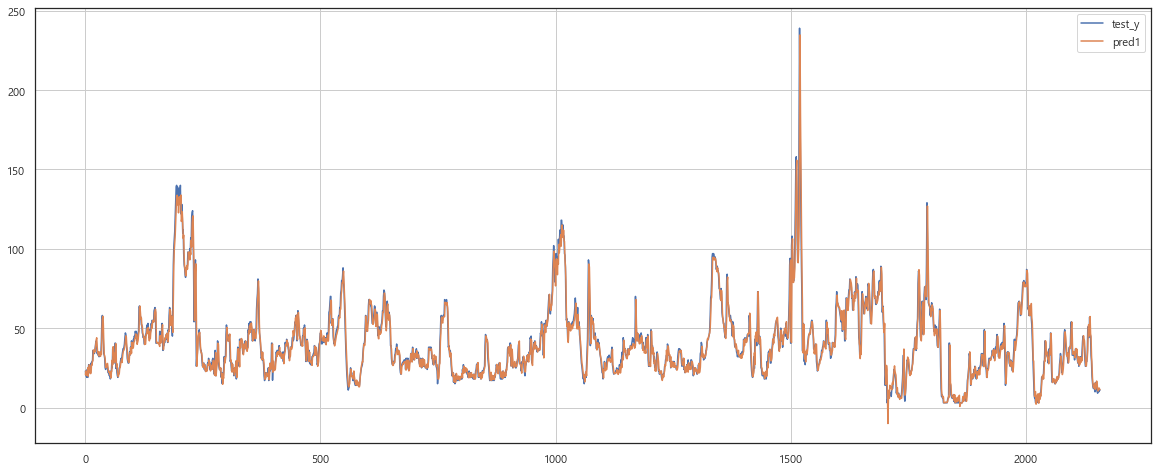

In [11]:
pred1 = pd.Series(pred1, index = test_y.index)

plt.figure(figsize = (20,8))
plt.plot(test_y, label = 'test_y')
plt.plot(pred1, label = 'pred1')

plt.legend()
plt.grid()
plt.show()

### 2) 선형회귀 전진선택법

In [12]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

def forward_stepwise_linear(x_train, y_train):

    # 변수목록, 선택된 변수 목록, 단계별 모델과 AIC 저장소 정의
    features = list(x_train)
    selected = []
    step_df = pd.DataFrame({ 'step':[], 'feature':[],'aic':[]})

    # 
    for s in range(0, len(features)) :
        result =  { 'step':[], 'feature':[],'aic':[]}

        # 변수 목록에서 변수 한개씩 뽑아서 모델에 추가
        for f in features :
            vars = selected + [f]
            x_tr = x_train[vars]
            model = OLS(y_train, add_constant(x_tr)).fit(disp=False)
            result['step'].append(s+1)
            result['feature'].append(vars)
            result['aic'].append(model.aic)
        
        # 모델별 aic 집계
        temp = pd.DataFrame(result).sort_values('aic').reset_index(drop = True)

        # 만약 이전 aic보다 새로운 aic 가 크다면 멈추기
        if step_df['aic'].min() < temp['aic'].min() :
            break
        step_df = pd.concat([step_df, temp], axis = 0).reset_index(drop = True)

        # 선택된 변수 제거
        v = temp.loc[0,'feature'][s]
        features.remove(v)

        selected.append(v)
    
    # 선택된 변수와 step_df 결과 반환
    return selected, step_df

In [13]:
vars, result = forward_stepwise_linear(train_x, train_y)
print(vars)

['PM10', '시정(10m)', '강수량(mm)', 'PM25', 'mean', 'O3+NO2', '풍향(16방위)', 'hot_summer2', '습도(%)', 'O3', '전운량(10분위)', 'NO2']


In [14]:
lr_selected=LinearRegression()
lr_selected.fit(train_x[vars], train_y)

pred1_selected= lr_selected.predict(test_x[vars])

In [15]:
K=12
tscv = TimeSeriesSplit(n_splits=K)

R2=[]
RMSE=[]
MAE=[]
MAPE=[]

model=lr_selected

for i, (train_index, val_index) in enumerate(tscv.split(train_x)):
    print(f'{i+1:2d} 번째 CV : Train 길이 {len(train_index):4d} & Val: {len(val_index)}')
    X_train, X_val = train_x.loc[list(train_index),list(vars)], train_x.loc[list(val_index),list(vars)]
    y_train, y_val = train_y[train_index], train_y[val_index]

    model.fit(X_train, y_train)
    pred=model.predict(X_val)
    
    R2.append(r2_score(y_val, pred))
    RMSE.append(mean_squared_error(y_val, pred, squared = False))
    MAE.append(mean_absolute_error(y_val, pred))
    MAPE.append(mean_absolute_percentage_error(y_val, pred))

print()

print('R2 : ', round(sum(R2)/K,4))
print('RMSE : ', round(sum(RMSE)/K,4))
print('MAE  : ', round(sum(MAE)/K,4))
print('MAPE : ', round(sum(MAPE)/K,4))  

 1 번째 CV : Train 길이  682 & Val: 673
 2 번째 CV : Train 길이 1355 & Val: 673
 3 번째 CV : Train 길이 2028 & Val: 673
 4 번째 CV : Train 길이 2701 & Val: 673
 5 번째 CV : Train 길이 3374 & Val: 673
 6 번째 CV : Train 길이 4047 & Val: 673
 7 번째 CV : Train 길이 4720 & Val: 673
 8 번째 CV : Train 길이 5393 & Val: 673
 9 번째 CV : Train 길이 6066 & Val: 673
10 번째 CV : Train 길이 6739 & Val: 673
11 번째 CV : Train 길이 7412 & Val: 673
12 번째 CV : Train 길이 8085 & Val: 673

R2 :  0.9123
RMSE :  7.8126
MAE  :  4.2649
MAPE :  0.1528


In [16]:
print('R2 SCORE : ', r2_score(test_y, pred1_selected))
print('RMSE : ', mean_squared_error(test_y, pred1_selected, squared = False))
print('MAE  : ', mean_absolute_error(test_y, pred1_selected))
print('MAPE : ', mean_absolute_percentage_error(test_y, pred1_selected))

R2 SCORE :  0.9248129873111799
RMSE :  6.412025923896111
MAE  :  3.986816868933847
MAPE :  0.12342386955341707


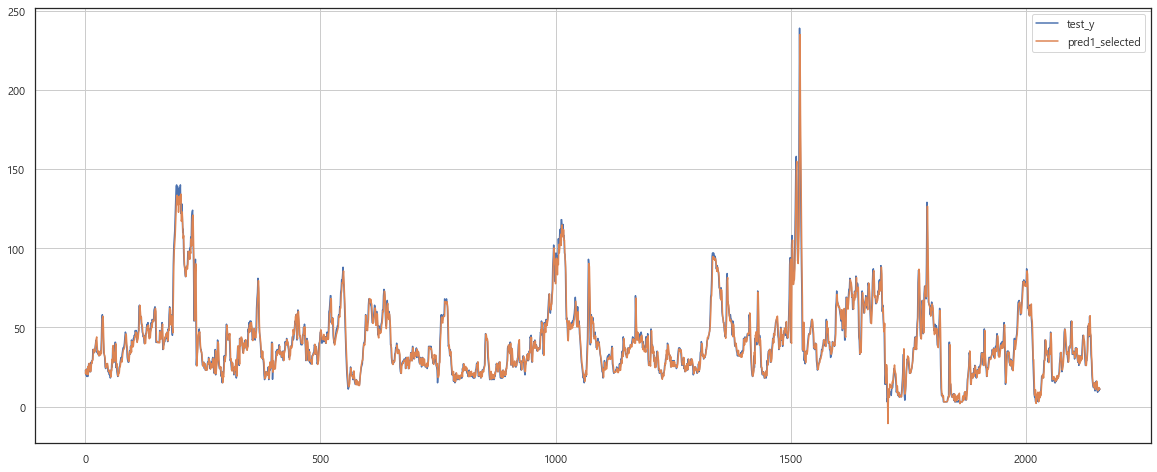

In [17]:
pred1_selected = pd.Series(pred1_selected, index = test_y.index)

plt.figure(figsize = (20,8))
plt.plot(test_y, label = 'test_y')
plt.plot(pred1_selected, label = 'pred1_selected')

plt.legend()
plt.grid()
plt.show()

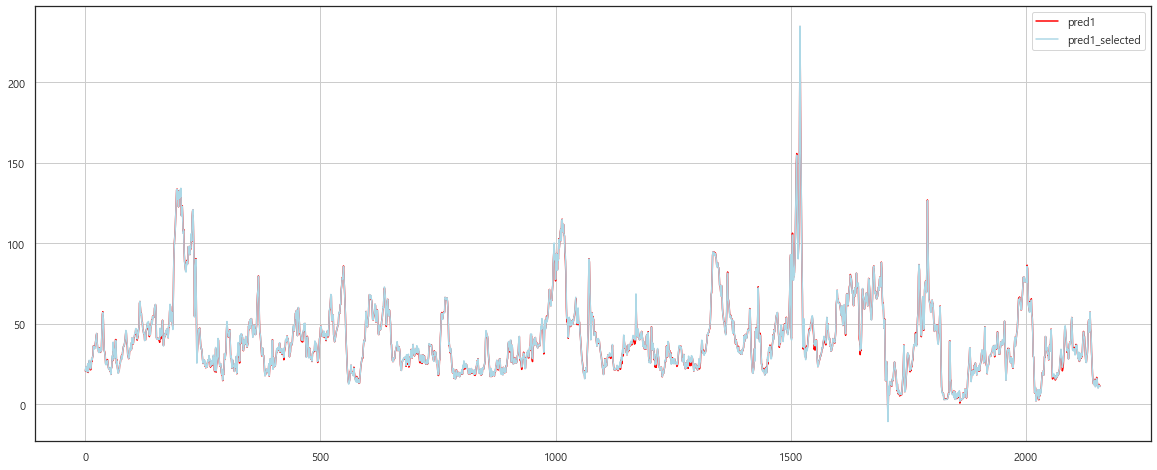

In [18]:
plt.figure(figsize = (20,8))
plt.plot(pred1, label='pred1',color='red')
plt.plot(pred1_selected, label = 'pred1_selected', color='lightblue')

plt.legend()
plt.grid()
plt.show()

## 2. Random Forest

### 1) Default Model & Time-Series Cross-Validation

In [19]:
# 1. 모델 선언
rf=RandomForestRegressor()
rf.fit(train_x, train_y)

RandomForestRegressor()

In [20]:
# 2. Time Series Cross Validation
from sklearn.model_selection import TimeSeriesSplit

K=12
tscv = TimeSeriesSplit(n_splits=K)

R2=[]
RMSE=[]
MAE=[]
MAPE=[]
    
for i, (train_index, val_index) in enumerate(tscv.split(train_x)):
    print(f'{i+1:2d} 번째 CV : Train 길이 {len(train_index):4d} & Val: {len(val_index)}')
    X_train, X_val = train_x.loc[list(train_index),:], train_x.loc[list(val_index),:]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    model=RandomForestRegressor()
    model.fit(X_train, y_train)
    pred=model.predict(X_val)
    
    R2.append(r2_score(y_val, pred))
    RMSE.append(mean_squared_error(y_val, pred, squared = False))
    MAE.append(mean_absolute_error(y_val, pred))
    MAPE.append(mean_absolute_percentage_error(y_val, pred))

print()

print('R2 : ', round(sum(R2)/K,4))
print('RMSE : ', round(sum(RMSE)/K,4))
print('MAE  : ', round(sum(MAE)/K,4))
print('MAPE : ', round(sum(MAPE)/K,4))  

 1 번째 CV : Train 길이  682 & Val: 673
 2 번째 CV : Train 길이 1355 & Val: 673
 3 번째 CV : Train 길이 2028 & Val: 673
 4 번째 CV : Train 길이 2701 & Val: 673
 5 번째 CV : Train 길이 3374 & Val: 673
 6 번째 CV : Train 길이 4047 & Val: 673
 7 번째 CV : Train 길이 4720 & Val: 673
 8 번째 CV : Train 길이 5393 & Val: 673
 9 번째 CV : Train 길이 6066 & Val: 673
10 번째 CV : Train 길이 6739 & Val: 673
11 번째 CV : Train 길이 7412 & Val: 673
12 번째 CV : Train 길이 8085 & Val: 673

R2 :  0.8659
RMSE :  13.1294
MAE  :  5.7713
MAPE :  0.1617


In [21]:
pred2= rf.predict(test_x)

print('R2 SCORE : ', r2_score(test_y, pred2))
print('RMSE : ', mean_squared_error(test_y, pred2, squared = False))
print('MAE  : ', mean_absolute_error(test_y, pred2))
print('MAPE : ', mean_absolute_percentage_error(test_y, pred2))

R2 SCORE :  0.9174749722208146
RMSE :  6.717639505246654
MAE  :  4.153787016378846
MAPE :  0.13094527193504252


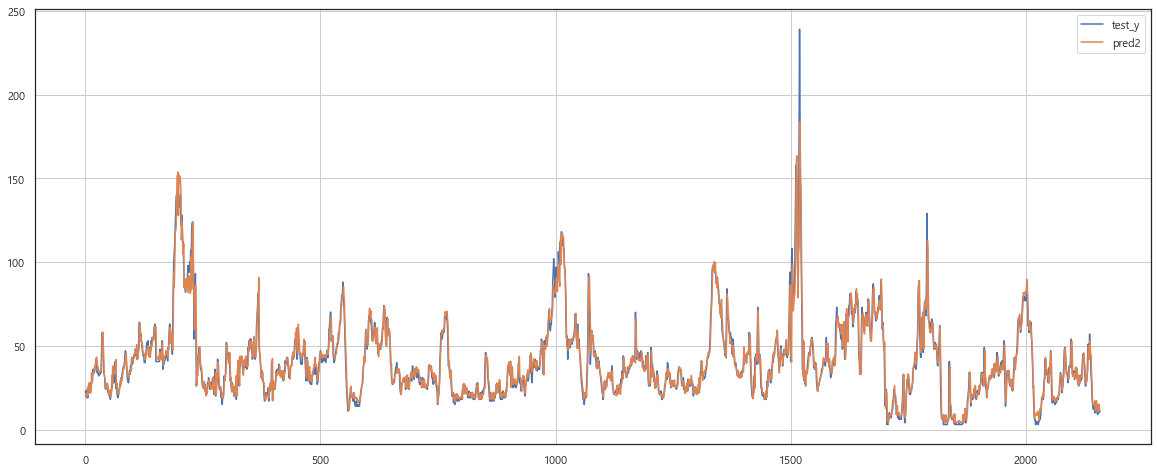

In [22]:
pred2 = pd.Series(pred2, index = test_y.index)

plt.figure(figsize = (20,8))
plt.plot(test_y, label = 'test_y')
plt.plot(pred2, label = 'pred2')

plt.legend()
plt.grid()
plt.show()

### 2) TSCV + GridSearchCV

In [36]:
from sklearn.model_selection import GridSearchCV

# from sklearn.metrics import make_scorer
# def RMSE(y_val, pred):
#     return mean_squared_error(y_val, pred, squared = False)
# rmse_score = make_scorer(RMSE, greater_is_better = False) 
 
params={'max_depth':range(10,15),'min_samples_leaf':range(1,5)} 

rf=RandomForestRegressor()

tscv = TimeSeriesSplit(n_splits=12)

rf_gs= GridSearchCV(estimator=rf, param_grid=params, cv=tscv, scoring = 'neg_root_mean_squared_error', verbose=3)
rf_gs.fit(train_x, train_y)

print(rf_gs.best_score_ , rf_gs.best_estimator_)

Fitting 12 folds for each of 20 candidates, totalling 240 fits
[CV 1/12] END ..............max_depth=10, min_samples_leaf=1; total time=   0.4s
[CV 2/12] END ..............max_depth=10, min_samples_leaf=1; total time=   0.7s
[CV 3/12] END ..............max_depth=10, min_samples_leaf=1; total time=   1.1s
[CV 4/12] END ..............max_depth=10, min_samples_leaf=1; total time=   1.5s
[CV 5/12] END ..............max_depth=10, min_samples_leaf=1; total time=   1.9s
[CV 6/12] END ..............max_depth=10, min_samples_leaf=1; total time=   2.5s
[CV 7/12] END ..............max_depth=10, min_samples_leaf=1; total time=   3.0s
[CV 8/12] END ..............max_depth=10, min_samples_leaf=1; total time=   3.3s
[CV 9/12] END ..............max_depth=10, min_samples_leaf=1; total time=   3.7s
[CV 10/12] END .............max_depth=10, min_samples_leaf=1; total time=   3.7s
[CV 11/12] END .............max_depth=10, min_samples_leaf=1; total time=   4.4s
[CV 12/12] END .............max_depth=10, min_

In [37]:
# max_depth=14, min_samples_leaf=3
pred2_gs=rf_gs.best_estimator_.predict(test_x)

print('R2 SCORE : ', r2_score(test_y, pred2_gs))
print('RMSE : ', mean_squared_error(test_y, pred2_gs, squared = False))
print('MAE  : ', mean_absolute_error(test_y, pred2_gs))
print('MAPE : ', mean_absolute_percentage_error(test_y, pred2_gs))

R2 SCORE :  0.9260950045928369
RMSE :  6.357125010712704
MAE  :  3.9849930443713593
MAPE :  0.12458923351918523


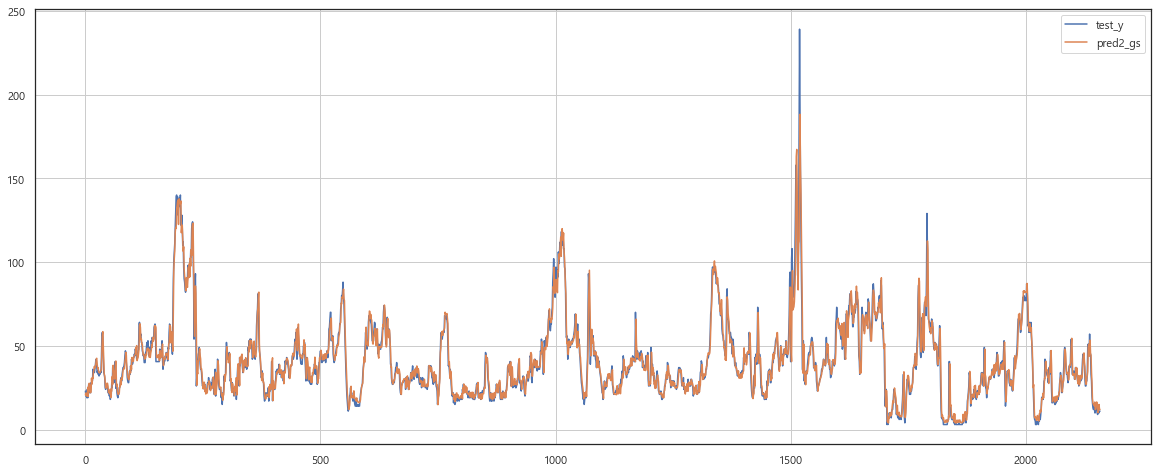

In [64]:
pred2_gs = pd.Series(pred2_gs, index = test_y.index)

plt.figure(figsize = (20,8))
plt.plot(test_y, label = 'test_y')
plt.plot(pred2_gs, label = 'pred2_gs')

plt.legend()
plt.grid()
plt.show()

In [38]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.reset_index(drop=True, inplace = True)

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

    return fi_df

In [23]:
result2 = plot_feature_importance(rf_gs.best_estimator_.feature_importances_, list(train_x))

NameError: name 'plot_feature_importance' is not defined

In [24]:
var2=['PM10','PM25', '시정(10m)']

rf_selected=RandomForestRegressor(max_depth=14, min_samples_leaf=3)
rf_selected.fit(train_x[var2], train_y)


RandomForestRegressor(max_depth=14, min_samples_leaf=3)

In [25]:
K=12
tscv = TimeSeriesSplit(n_splits=K)

R2=[]
RMSE=[]
MAE=[]
MAPE=[]

model=rf_selected

for i, (train_index, val_index) in enumerate(tscv.split(train_x)):
    print(f'{i+1:2d} 번째 CV : Train 길이 {len(train_index):4d} & Val: {len(val_index)}')
    X_train, X_val = train_x.loc[list(train_index),var2], train_x.loc[list(val_index),var2]
    y_train, y_val = train_y[train_index], train_y[val_index]

    model.fit(X_train, y_train)
    pred=model.predict(X_val)
    
    R2.append(r2_score(y_val, pred))
    RMSE.append(mean_squared_error(y_val, pred, squared = False))
    MAE.append(mean_absolute_error(y_val, pred))
    MAPE.append(mean_absolute_percentage_error(y_val, pred))

print()

print('R2 : ', round(sum(R2)/K,4))
print('RMSE : ', round(sum(RMSE)/K,4))
print('MAE  : ', round(sum(MAE)/K,4))
print('MAPE : ', round(sum(MAPE)/K,4))  

 1 번째 CV : Train 길이  682 & Val: 673
 2 번째 CV : Train 길이 1355 & Val: 673
 3 번째 CV : Train 길이 2028 & Val: 673
 4 번째 CV : Train 길이 2701 & Val: 673
 5 번째 CV : Train 길이 3374 & Val: 673
 6 번째 CV : Train 길이 4047 & Val: 673
 7 번째 CV : Train 길이 4720 & Val: 673
 8 번째 CV : Train 길이 5393 & Val: 673
 9 번째 CV : Train 길이 6066 & Val: 673
10 번째 CV : Train 길이 6739 & Val: 673
11 번째 CV : Train 길이 7412 & Val: 673
12 번째 CV : Train 길이 8085 & Val: 673

R2 :  0.8759
RMSE :  12.2453
MAE  :  5.2829
MAPE :  0.1503


In [26]:
pred2_selected=rf_selected.predict(test_x[var2])

print('R2 SCORE : ', r2_score(test_y, pred2_selected))
print('RMSE : ', mean_squared_error(test_y, pred2_selected, squared = False))
print('MAE  : ', mean_absolute_error(test_y, pred2_selected))
print('MAPE : ', mean_absolute_percentage_error(test_y, pred2_selected))

R2 SCORE :  0.9283350724899262
RMSE :  6.260041143169965
MAE  :  4.099981637158244
MAPE :  0.1240073660648027


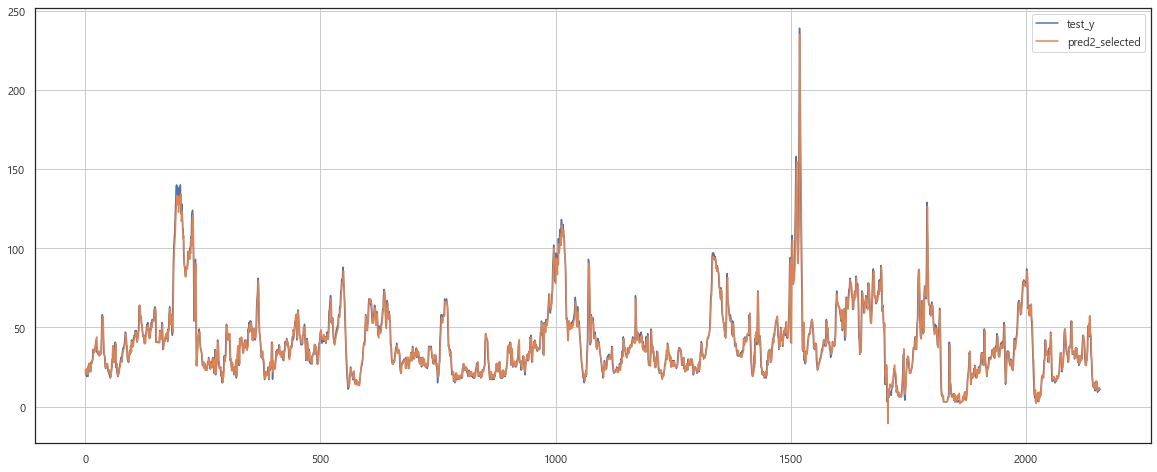

In [27]:
pred2_selected = pd.Series(pred1_selected, index = test_y.index)

plt.figure(figsize = (20,8))
plt.plot(test_y, label = 'test_y')
plt.plot(pred1_selected, label = 'pred2_selected')

plt.legend()
plt.grid()
plt.show()

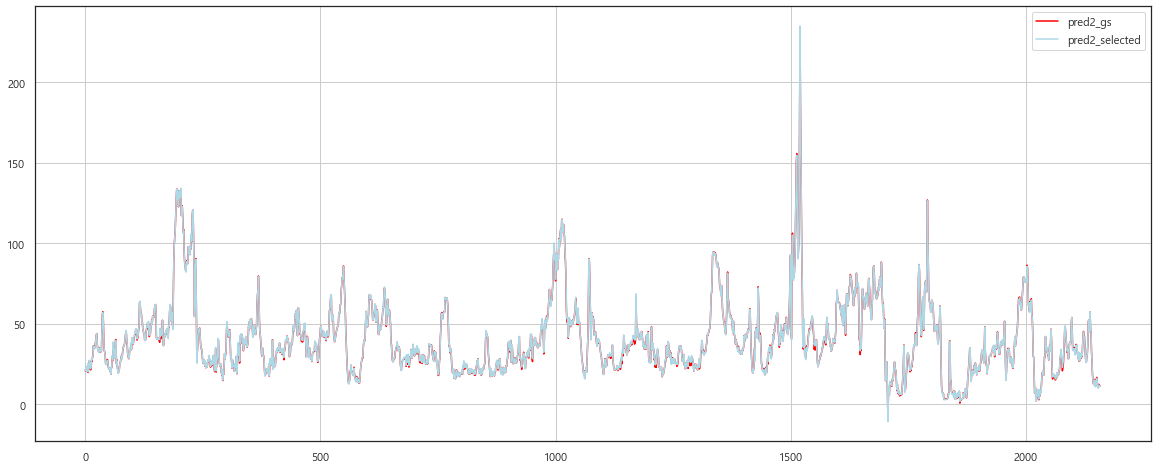

In [68]:
plt.figure(figsize = (20,8))
plt.plot(pred1, label='pred2_gs',color='red')
plt.plot(pred1_selected, label = 'pred2_selected', color='lightblue')

plt.legend()
plt.grid()
plt.show()

## 3. Gradient Boosting

### 1) Default Model & Time-Series Cross-Validation

In [15]:
# 1. 모델 선언
xgb=XGBRegressor(objective='reg:squarederror')
xgb.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [16]:
# 2. Time Series Cross Validation
from sklearn.model_selection import TimeSeriesSplit

K=12
tscv = TimeSeriesSplit(n_splits=K)

R2=[]
RMSE=[]
MAE=[]
MAPE=[]
    
for i, (train_index, val_index) in enumerate(tscv.split(train_x)):
    print(f'{i+1:2d} 번째 CV : Train 길이 {len(train_index):4d} & Val: {len(val_index)}')
    X_train, X_val = train_x.loc[list(train_index),:], train_x.loc[list(val_index),:]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    model=XGBRegressor(objective='reg:squarederror')
    model.fit(X_train, y_train)
    pred=model.predict(X_val)
    
    R2.append(r2_score(y_val, pred))
    RMSE.append(mean_squared_error(y_val, pred, squared = False))
    MAE.append(mean_absolute_error(y_val, pred))
    MAPE.append(mean_absolute_percentage_error(y_val, pred))

print()

print('R2 : ', round(sum(R2)/K,4))
print('RMSE : ', round(sum(RMSE)/K,4))
print('MAE  : ', round(sum(MAE)/K,4))
print('MAPE : ', round(sum(MAPE)/K,4))  

 1 번째 CV : Train 길이  682 & Val: 673
 2 번째 CV : Train 길이 1355 & Val: 673
 3 번째 CV : Train 길이 2028 & Val: 673
 4 번째 CV : Train 길이 2701 & Val: 673
 5 번째 CV : Train 길이 3374 & Val: 673
 6 번째 CV : Train 길이 4047 & Val: 673
 7 번째 CV : Train 길이 4720 & Val: 673
 8 번째 CV : Train 길이 5393 & Val: 673
 9 번째 CV : Train 길이 6066 & Val: 673
10 번째 CV : Train 길이 6739 & Val: 673
11 번째 CV : Train 길이 7412 & Val: 673
12 번째 CV : Train 길이 8085 & Val: 673

R2 :  0.8464
RMSE :  14.0975
MAE  :  6.2722
MAPE :  0.1803


In [17]:
pred3= xgb.predict(test_x)

print('R2 SCORE : ', r2_score(test_y, pred3))
print('RMSE : ', mean_squared_error(test_y, pred3, squared = False))
print('MAE  : ', mean_absolute_error(test_y, pred3))
print('MAPE : ', mean_absolute_percentage_error(test_y, pred3))

R2 SCORE :  0.925114536673041
RMSE :  6.3997883150864885
MAE  :  4.129784507952373
MAPE :  0.131908463084569


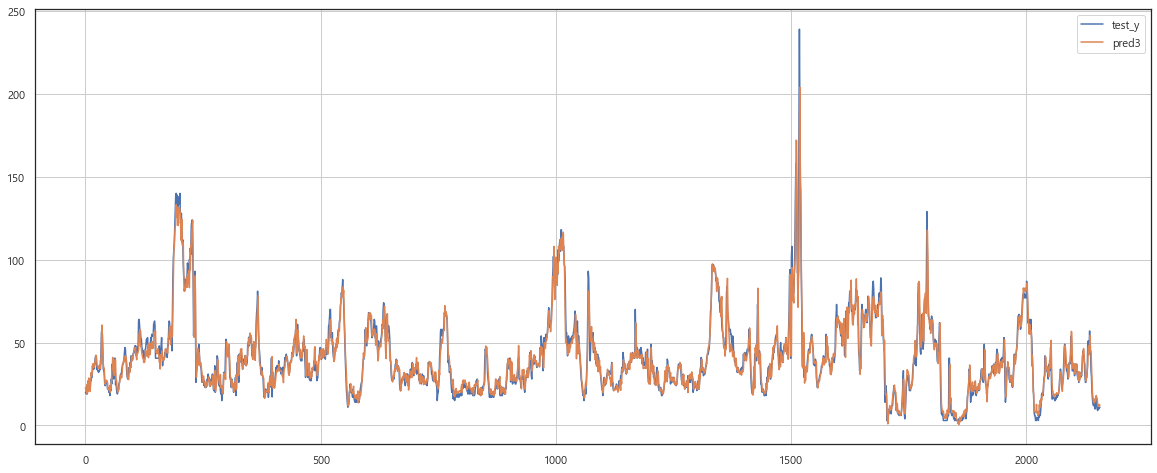

In [19]:
pred3 = pd.Series(pred3, index = test_y.index)

plt.figure(figsize = (20,8))
plt.plot(test_y, label = 'test_y')
plt.plot(pred3, label = 'pred3')

plt.legend()
plt.grid()
plt.show()

### 2) TSCV + GridSearchCV

In [20]:
from sklearn.model_selection import GridSearchCV

# from sklearn.metrics import make_scorer
# def RMSE(y_val, pred):
#     return mean_squared_error(y_val, pred, squared = False)
# rmse_score = make_scorer(RMSE, greater_is_better = False) 
 
params={'learning_rate':np.linspace(0.01,0.2,10), 'max_depth':[3,4,5], 'n_estimators':range(100,221,20)}

xgb=XGBRegressor(objective='reg:squarederror')

tscv = TimeSeriesSplit(n_splits=12)

xgb_gs= GridSearchCV(estimator=xgb, param_grid=params, cv=tscv, scoring = 'neg_root_mean_squared_error', verbose=3)
xgb_gs.fit(train_x, train_y)

print(xgb_gs.best_score_ , xgb_gs.best_estimator_)

Fitting 12 folds for each of 210 candidates, totalling 2520 fits
[CV 1/12] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-23.728 total time=   0.0s
[CV 2/12] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-26.777 total time=   0.1s
[CV 3/12] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-57.261 total time=   0.0s
[CV 4/12] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-82.519 total time=   0.1s
[CV 5/12] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-22.990 total time=   0.1s
[CV 6/12] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-10.812 total time=   0.1s
[CV 7/12] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-8.183 total time=   0.1s
[CV 8/12] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-8.518 total time=   0.2s
[CV 9/12] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-8.538 total time=   0.2s
[CV 10/12] END learning_rate=0.01, max_depth=3,

In [25]:
print(xgb_gs.best_score_ , xgb_gs.best_params_)

-12.641928380998637 {'learning_rate': 0.052222222222222225, 'max_depth': 3, 'n_estimators': 200}


In [21]:
# learning_rate=0.09444444444444444, max_depth=3, n_estimators=100
pred3_gs=xgb_gs.best_estimator_.predict(test_x)

print('R2 SCORE : ', r2_score(test_y, pred3_gs))
print('RMSE : ', mean_squared_error(test_y, pred3_gs, squared = False))
print('MAE  : ', mean_absolute_error(test_y, pred3_gs))
print('MAPE : ', mean_absolute_percentage_error(test_y, pred3_gs))

R2 SCORE :  0.9331465597363824
RMSE :  6.046843504367888
MAE  :  3.849049388047421
MAPE :  0.12870901426730352


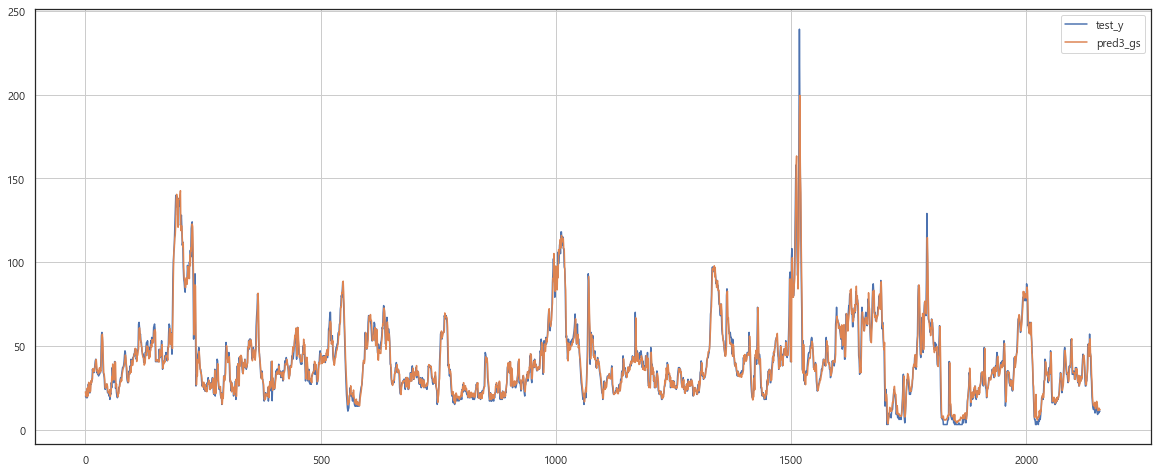

In [22]:
pred3_gs = pd.Series(pred3_gs, index = test_y.index)

plt.figure(figsize = (20,8))
plt.plot(test_y, label = 'test_y')
plt.plot(pred3_gs, label = 'pred3_gs')

plt.legend()
plt.grid()
plt.show()

In [23]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.reset_index(drop=True, inplace = True)

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

    return fi_df

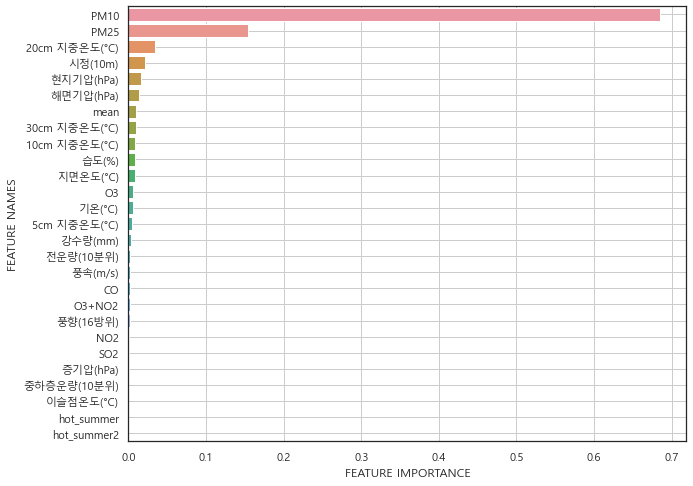

In [31]:
result3 = plot_feature_importance(xgb_gs.best_estimator_.feature_importances_, list(train_x))

In [32]:
var3=['PM10','PM25', '20cm 지중온도(°C)', '시정(10m)', '현지기압(hPa)', '해면기압(hPa)']

xgb_selected=XGBRegressor(objective='reg:squarederror', learning_rate=0.09444444444444444, max_depth=3, n_estimators=100)
xgb_selected.fit(train_x[var3], train_y)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.09444444444444444, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, ...)

In [33]:
K=12
tscv = TimeSeriesSplit(n_splits=K)

R2=[]
RMSE=[]
MAE=[]
MAPE=[]

model= xgb_selected

for i, (train_index, val_index) in enumerate(tscv.split(train_x)):
    print(f'{i+1:2d} 번째 CV : Train 길이 {len(train_index):4d} & Val: {len(val_index)}')
    X_train, X_val = train_x.loc[list(train_index),var3], train_x.loc[list(val_index),var3]
    y_train, y_val = train_y[train_index], train_y[val_index]

    model.fit(X_train, y_train)
    pred=model.predict(X_val)
    
    R2.append(r2_score(y_val, pred))
    RMSE.append(mean_squared_error(y_val, pred, squared = False))
    MAE.append(mean_absolute_error(y_val, pred))
    MAPE.append(mean_absolute_percentage_error(y_val, pred))

print()

print('R2 : ', round(sum(R2)/K,4))
print('RMSE : ', round(sum(RMSE)/K,4))
print('MAE  : ', round(sum(MAE)/K,4))
print('MAPE : ', round(sum(MAPE)/K,4))  

 1 번째 CV : Train 길이  682 & Val: 673
 2 번째 CV : Train 길이 1355 & Val: 673
 3 번째 CV : Train 길이 2028 & Val: 673
 4 번째 CV : Train 길이 2701 & Val: 673
 5 번째 CV : Train 길이 3374 & Val: 673
 6 번째 CV : Train 길이 4047 & Val: 673
 7 번째 CV : Train 길이 4720 & Val: 673
 8 번째 CV : Train 길이 5393 & Val: 673
 9 번째 CV : Train 길이 6066 & Val: 673
10 번째 CV : Train 길이 6739 & Val: 673
11 번째 CV : Train 길이 7412 & Val: 673
12 번째 CV : Train 길이 8085 & Val: 673

R2 :  0.874
RMSE :  12.675
MAE  :  5.6738
MAPE :  0.1717


In [34]:
pred3_selected=xgb_selected.predict(test_x[var3])

print('R2 SCORE : ', r2_score(test_y, pred3_selected))
print('RMSE : ', mean_squared_error(test_y, pred3_selected, squared = False))
print('MAE  : ', mean_absolute_error(test_y, pred3_selected))
print('MAPE : ', mean_absolute_percentage_error(test_y, pred3_selected))

R2 SCORE :  0.9273698833131228
RMSE :  6.3020555291825024
MAE  :  4.034859723501296
MAPE :  0.13497111136424234


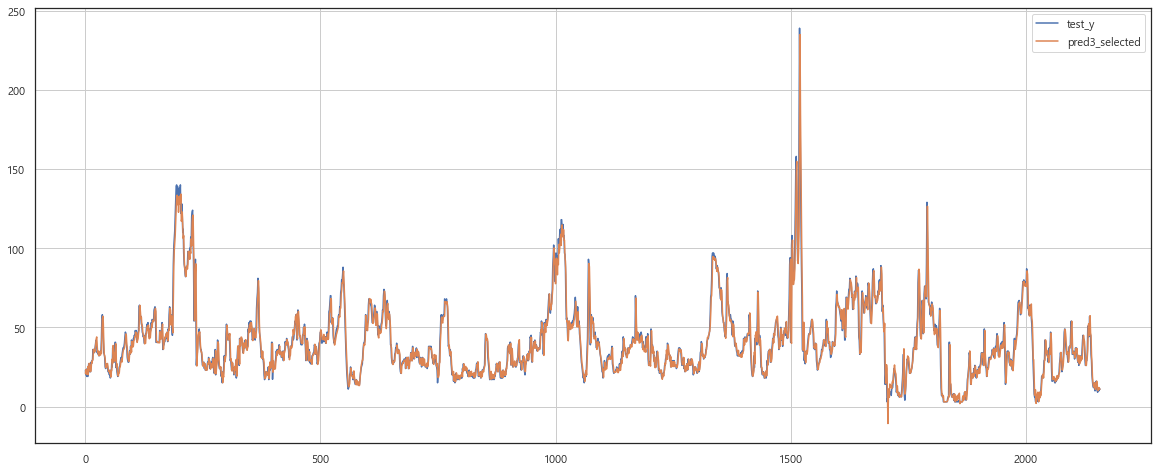

In [35]:
pred3_selected = pd.Series(pred1_selected, index = test_y.index)

plt.figure(figsize = (20,8))
plt.plot(test_y, label = 'test_y')
plt.plot(pred1_selected, label = 'pred3_selected')

plt.legend()
plt.grid()
plt.show()

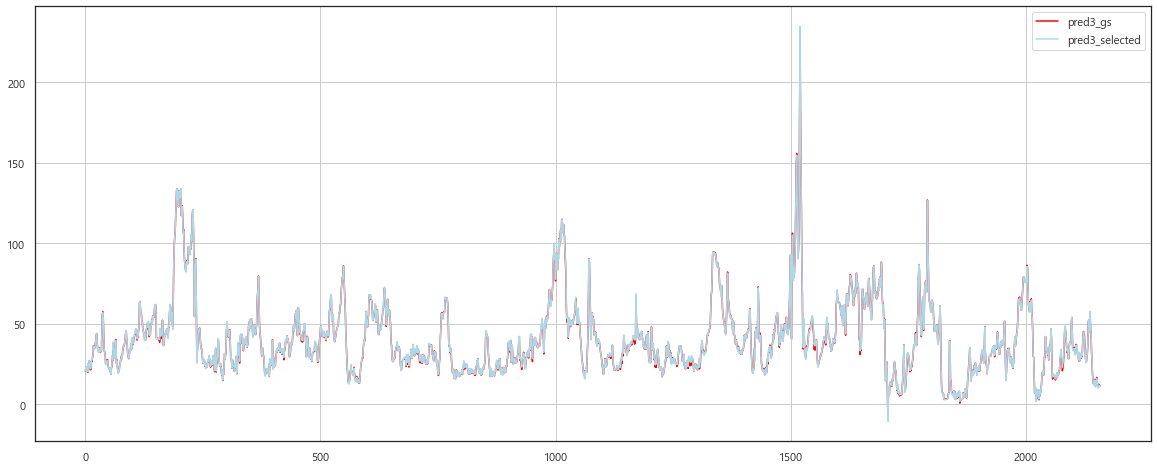

In [69]:
plt.figure(figsize = (20,8))
plt.plot(pred1, label='pred3_gs',color='red')
plt.plot(pred1_selected, label = 'pred3_selected', color='lightblue')

plt.legend()
plt.grid()
plt.show()

# [2] 결과

In [29]:
ret=pd.DataFrame({'model':['LR', 'LR_selected', 'RF_tscv', 'RF_tscv_gs', 'RF_selected', 'XGB_tscv', 'XGB_tscv_gs', 'XGB_selected'],
                  'R2 score': [r2_score(test_y, pred1), r2_score(test_y, pred1_selected),
                               r2_score(test_y, pred2),r2_score(test_y, pred2_gs),r2_score(test_y, pred2_selected),
                               r2_score(test_y, pred3),r2_score(test_y, pred3_gs),r2_score(test_y, pred3_selected)],
                  'RMSE' : [mean_squared_error(test_y, pred1, squared = False), mean_squared_error(test_y, pred1_selected, squared = False),
                          mean_squared_error(test_y, pred2, squared = False), mean_squared_error(test_y, pred2_gs, squared = False), mean_squared_error(test_y, pred2_selected, squared = False),
                          mean_squared_error(test_y, pred3, squared = False), mean_squared_error(test_y, pred3_gs, squared = False), mean_squared_error(test_y, pred3_selected, squared = False)],
                  'MAE' : [mean_absolute_error(test_y, pred1), mean_absolute_error(test_y, pred1_selected),
                          mean_absolute_error(test_y, pred2), mean_absolute_error(test_y, pred2_gs), mean_absolute_error(test_y, pred2_selected),
                          mean_absolute_error(test_y, pred3), mean_absolute_error(test_y, pred3_gs), mean_absolute_error(test_y, pred3_selected)],
                  'MAPE' : [mean_absolute_percentage_error(test_y, pred1), mean_absolute_percentage_error(test_y, pred1_selected),
                         mean_absolute_percentage_error(test_y, pred2), mean_absolute_percentage_error(test_y, pred2_gs), mean_absolute_percentage_error(test_y, pred2_selected),
                         mean_absolute_percentage_error(test_y, pred3), mean_absolute_percentage_error(test_y, pred3_gs), mean_absolute_percentage_error(test_y, pred3_selected)],
                 })
ret

NameError: name 'pred2' is not defined